# Model Training and OCR Detection

In the notebook we will be training our model for finding the boundary box on the form, and also try to perform OCR on the cropped section of the image. This model will be very similar to an object recognition problem, and we will be using PyTorch and the fasterrcnn_resnet50_fpn model to fine tune for our specific needs.

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from PIL import Image
from xml.etree import ElementTree as ET
from tqdm import tqdm

## Setup Dataset

We first need to setup our dataset into a format that PyTorch can understand. In the other notebook we already filter out to only have our first pages, and we also used labelImg to label all the boundary boxes and got our coordinates in the xml files. So now we just need to load it into the CustomDataset class.

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = self.load_annotations()

    def __getitem__(self, idx):
        # Load image and annotations
        img_path = os.path.join(self.root, 
                                'sfrs_' + self.annotations[idx]['filename'][2], 
                                self.annotations[idx]['filename'][:-7], 
                                self.annotations[idx]['filename'])
        
        img = Image.open(img_path).convert("L")
        target = self.annotations[idx]['annotation']
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target

    def __len__(self):
        return len(self.annotations)

    def load_annotations(self):
        annotations = []
        # Parse XML files
        for root, dirs, files in os.walk(self.root):
            for xml_file in files:
                if xml_file.endswith(".xml"):
                    tree = ET.parse(os.path.join(root, xml_file))
                    root = tree.getroot()
                    annotation = {
                        'filename': root.find('filename').text,
                        'annotation': {
                            'boxes': [],
                            'labels': []
                        }
                    }
                    for obj in root.findall('object'):
                        box = obj.find('bndbox')
                        xmin = int(box.find('xmin').text)
                        ymin = int(box.find('ymin').text)
                        xmax = int(box.find('xmax').text)
                        ymax = int(box.find('ymax').text)

                        annotation['annotation']['boxes'].append([xmin, ymin, xmax, ymax])
                        annotation['annotation']['labels'].append(int(obj.find('name').text))

                    annotations.append(annotation)

        return annotations

### Transforming to torch.Tensor

We then need to transform our data into torch Tensor, and setup our dataloaders for the model to use later.

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = CustomDataset(root='../data/data', transforms=transform)

In [4]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
# NOTE THAT I AM USING THIS TO SPEED UP THE DEV
sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=6)

In [6]:
# Define data loaders
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                           shuffle=True,
                            num_workers=0,
                            # sampler=sampler
                          )
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=0)

### Loading Model

We will be using the fasterrcnn_resnet50_fpn model from pytorch library like mentioned before. We will try to use GPU to train the model because it's faster. However, CPU training is also available.

In [7]:
# Load a pre-trained Faster R-CNN model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Setting up training parameters

In [8]:
# Define the optimizer and the learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Define Training Loop 

In [9]:
# Define the training loop
def training_loop(num_epochs, batch_size): 
    model.train()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    for epoch in range(num_epochs):
        total_batches = len(train_loader)
        with tqdm(total=total_batches, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                targets = []
                for i in range(batch_size):
                    d = {}
                    d['boxes'] = torch.tensor([b[i] for b in labels['boxes'][0]]).unsqueeze(0).to(device)
                    d['labels'] = torch.tensor([labels['labels'][0][i]]).to(device)
                    targets.append(d)
                output = model(images, targets)
                losses = sum(loss for loss in output.values())
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                # Update the progress bar
                pbar.update(1)

        # Update the learning rate
        lr_scheduler.step()

    torch.save(model, '../models/findbox.pth')

### Training the model

We now can train our model. We will run for 10 Epochs with a batch_size of 4. With an RTX 3060, this training took about 20 minutes.

In [10]:
# Run the training
training_loop(10, batch_size=batch_size)

Epoch 10/10: 100%|████████████████████████████████████████████████████████████████| 180/180 [01:43<00:00,  1.75batch/s]


### Define function for showing result model

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].imshow(np.asarray(img))
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Testing model

We can now test our model with a new image. We can simply down the 1988 Form 1040 and fill it out using Adobe PDF Viewer. We put it in the data folder and named it as test_form. We can also tilt the image so that we can mimic a real life example of a not very good scan, and see how well the model can find the section we want.

The model will also output a bunch of boxes, but we only need to look at the one with the highest confidence score, and the other ones are basically just random sections that we don't want.

The results are actually pretty accurate, with a confidence score of 99.82%.

tensor([0.9982], device='cuda:0')


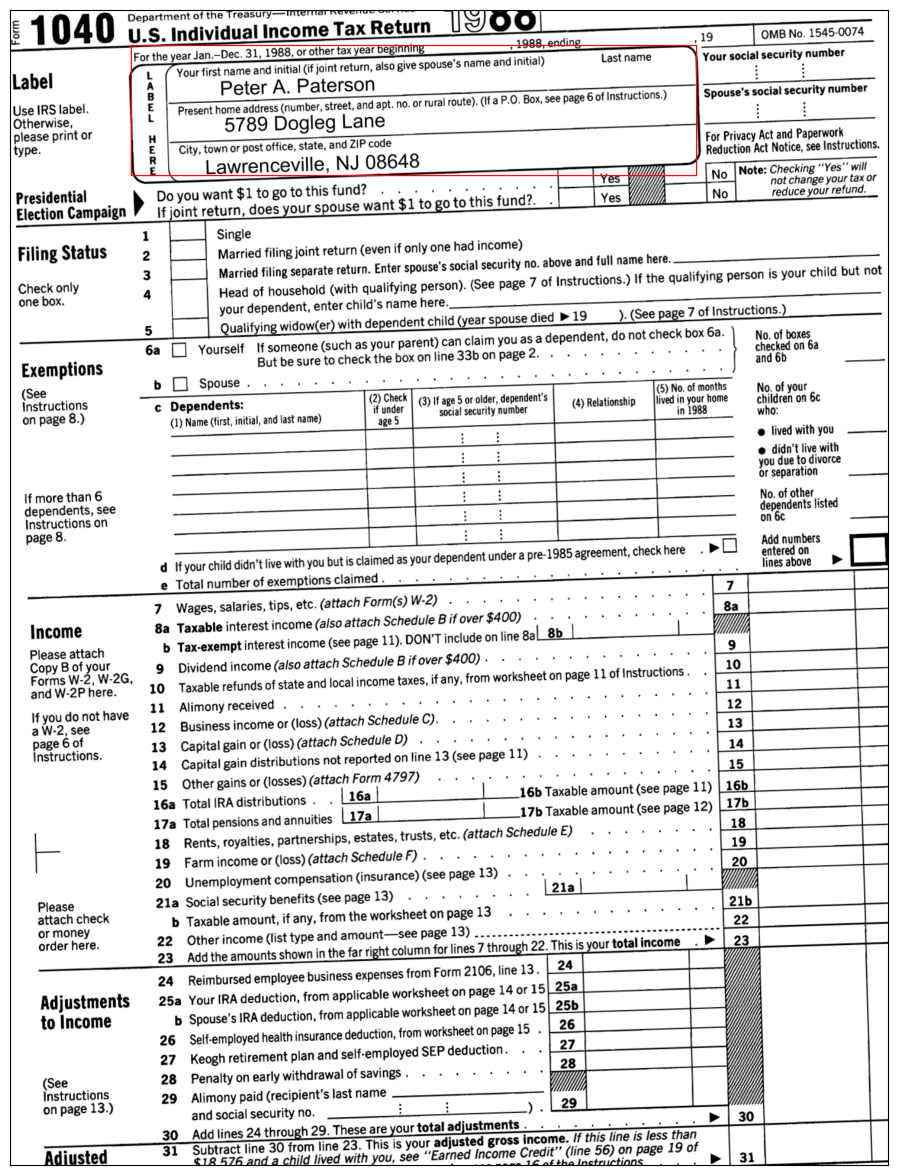

In [4]:
# define a function to test a new image
def test_model(img_path):
    model = torch.load('../models/findbox.pth')
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    original_img = Image.open(img_path).convert("L")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform(original_img).unsqueeze(0).to(device)
    output = model(img)
    boxes = output[0]['boxes'].detach().to(device)
    scores = output[0]['scores'].detach().to(device)

    # find the box with the highest condifence score
    max_score_idx = torch.argmax(scores)
    boxes = boxes[max_score_idx].unsqueeze(0)
    scores = scores[max_score_idx].unsqueeze(0)

    # Convert image into Tensor of shape (C x H x W) and dtype uint8
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(original_img)
    output_image = draw_bounding_boxes(image=img_tensor, boxes=boxes, colors=(255, 0, 0), width=2)
    print(scores)
    show(output_image)

    return boxes, scores

result_box = test_model('../data/test_form_tilted.png')



### Cropping Image

In order to do OCR on the image, we need to crop the image based on the boundary box the model output. We can simply use a function provided in the PIL library.

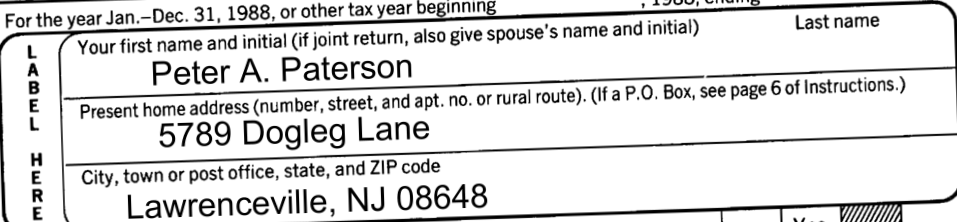

In [5]:
def cropImage(img_path, box):
    img = Image.open(img_path).convert("L")
    box = tuple(box[0].tolist())
    img = img.crop(box)
    img.save('../data/cropped.png')
    display(img)

cropped_img = cropImage("../data/test_form_tilted.png", result_box[0])

### OCR with easyocr

We can then use easyocr to read the text on the form. 

In [6]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext('../data/cropped.png')

### Results from easyocr

The esayocr library can get all the text exists on the image. However, it also comes with a bunch of text like "For the year Jan~Dec 31,1988". These are not the text that we want as we are only focusing the name and the address. Though it's good to see that the name and address are read correctly.

In [7]:
text_list = []
for text in result:
    t = [
        text[1],
        text[2]
    ]
    print(t)
    text_list.append(t)

['For the year Jan~Dec 31,1988', 0.4331400140177445]
['or other tax year beginning', 0.9321653968004429]
['Last name', 0.990033413114347]
["dirst name and initial (f joint return, also give spouse' $ name and initial)", 0.5840936013777234]
['Your', 0.9999391436576843]
['1', 0.2717830412607647]
['Peter A Paterson_', 0.8735613168906022]
['rural route). (If a P.O. Box, see page 6 of Instructions )', 0.6264296932836474]
['Present home address (number, street,', 0.7049947114452967]
['apt: no: or', 0.3855214699755348]
['5789 Dogleg Lane_', 0.5822234687849703]
['#', 0.7974921263335979]
['City, town or post office, state, and ZIP code', 0.7850306931383529]
['R', 0.9909156393226546]
['Lawrenceville, NJ 08648', 0.7920542009223241]
['and', 0.9999807288805623]


### Using Generative AI to Clean Results

Since cleaning the results can be tedious and it's not guaranteed we can cover all the unknown cases that easyocr outputs, it might be easier to just use Generative AI to parse the data. We are going to use the model provided by OpenAI (basically API version of ChatGPT), and it can even output in JSON format so that frontend can read easily.

In [13]:
from openai import OpenAI

def parseWithGPT(text_list):
    prompt = 'Extract full name and address from the easyocr result into json object named info.\n ' + ', '.join([f"('{item[0]}', {item[1]})" for item in text_list])
    data = {
        'content': prompt,
        'role': "user"
    }
    chatgpt =  OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    response = chatgpt.chat.completions.create(
        model='gpt-3.5-turbo-1106',
        response_format={ "type": "json_object" },
        messages=[data],
        temperature=0
    )
    return(response.choices[0].message.content)


gpt_response = parseWithGPT(text_list)

print(gpt_response)

{
  "info": {
    "full_name": "Peter A Paterson",
    "address": "5789 Dogleg Lane, Lawrenceville, NJ 08648"
  }
}
